# Librerias

In [12]:
import os
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Para quitar unos warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

# Regresión Lineal Variable Churn

**Lectura archivo Y extraccion datos**

In [17]:
# Conexión a SQL Server Local
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

conn_local = pyodbc.connect(local_conn_str)

# Leer la consulta desde la carpeta "queries"
BASE_DIR = os.getcwd()
queries_path = os.path.join(BASE_DIR, "..", "queries")
regresion_file = os.path.join(queries_path, "regresion_cliente.sql")
with open(regresion_file, 'r', encoding='utf-8') as file:
    regresion_query = file.read()

# Ejecutar la consulta y guardar en DataFrame
df_reg = pd.read_sql(regresion_query, conn_local)
print(f"Filas extraídas para regresión: {df_reg.shape[0]}")
print("Columnas extraídas:", ', '.join(list(df_reg.columns)))

conn_local.close()


Filas extraídas para regresión: 1011
Columnas extraídas: PVP, Numero_Compras, Edad_Media_Cliente, Edad_Media_Coche, Margen_Bruto_Medio, Margen_Eur_Medio, Renta_Media, Km_medio_por_revision, Dias_En_Taller, Coste_Total, churn_medio


In [18]:
df_reg

,PVP,Numero_Compras,Edad_Media_Cliente,Edad_Media_Coche,Margen_Bruto_Medio,Margen_Eur_Medio,Renta_Media,Km_medio_por_revision,Dias_En_Taller,Coste_Total,churn_medio
0,10528,174,42,2.057471,2947.840088,1420.462045,23566,17630,1.327586,1527.377921,0.293103
1,10909,162,41,2.314815,3054.520020,1676.102518,22945,14328,3.987654,1378.417502,0.246913
2,11004,239,43,2.054393,3081.120117,1755.825153,23215,16105,0.974895,1325.294842,0.284518
3,11100,2,47,3.500000,3108.000000,1720.000000,29759,39937,0.000000,1388.000000,1.000000
4,11237,89,44,2.089888,3146.360107,1197.343844,23823,18348,0.955056,1949.016141,0.292134
...,...,...,...,...,...,...,...,...,...,...,...
1006,36496,29,42,2.448276,12043.679688,360.542077,17480,7966,1.586207,11683.137931,0.000000
1007,36634,329,42,2.118541,15752.620117,13577.761098,17932,7552,1.340426,2174.859329,0.006079
1008,36771,122,40,2.188525,15811.530273,13651.938220,17215,9650,2.237705,2159.592122,0.016393
1009,37832,12,42,2.416667,12484.559570,213.310008,15680,7322,0.416667,12271.250000,0.000000


**Correlación vairables con Chunrn**

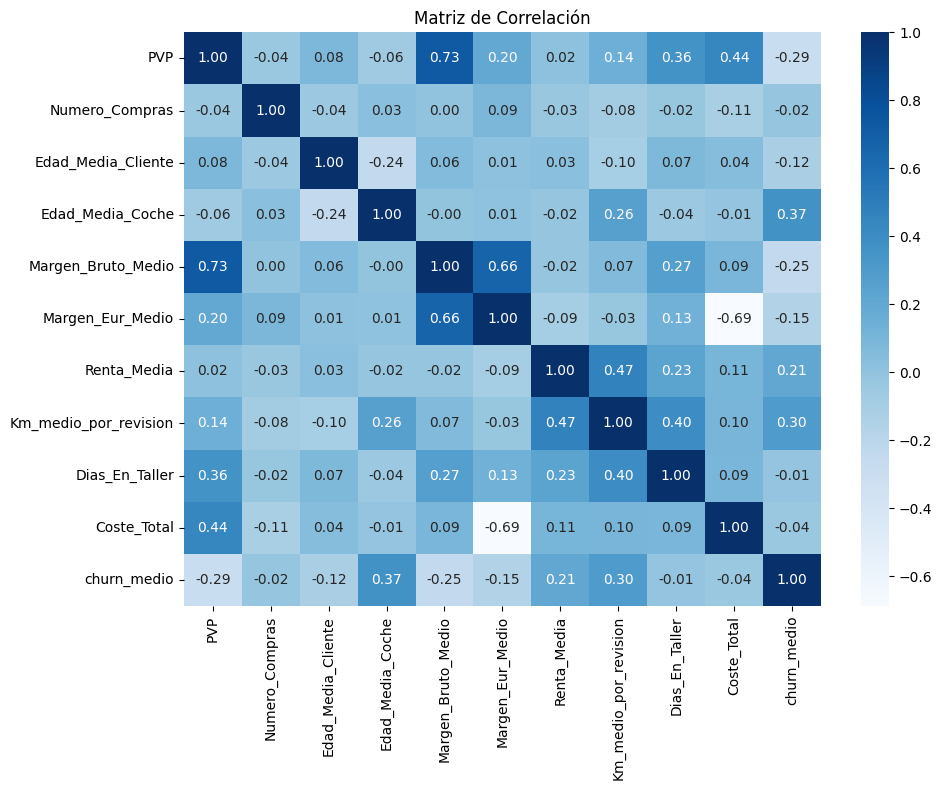

In [19]:
corr_matrix = df_reg.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()


**Regresión Lineal**

In [26]:
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Supongamos que ya has cargado df_reg con la consulta SQL
# df_reg = pd.read_sql(...)

# Variables candidatas
variables = [
    "Edad_Media_Coche",
    "Renta_Media",
    "PVP",
    "Margen_Bruto_Medio",
    "Margen_Eur_Medio",
    "Edad_Media_Cliente",
    "Km_medio_por_revision"
]

objetivo = "churn_medio"
resultados = []

# Probar todas las combinaciones de 3 variables
combinaciones = list(itertools.combinations(variables, 6))

for vars_comb in combinaciones:
    X = df_reg[list(vars_comb)]
    y = df_reg[objetivo]

    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    r2 = r2_score(y, y_pred)
    resultados.append((vars_comb, r2))

# Mostrar las mejores combinaciones ordenadas por R²
resultados.sort(key=lambda x: x[1], reverse=True)

print("Ranking de combinaciones por R²:\n")
for i, (vars_comb, r2) in enumerate(resultados[:5], 1):
    print(f"{i}. Variables: {vars_comb} → R²: {r2:.4f}")


Ranking de combinaciones por R²:

1. Variables: ('Edad_Media_Coche', 'Renta_Media', 'PVP', 'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Km_medio_por_revision') → R²: 0.2887
2. Variables: ('Edad_Media_Coche', 'Renta_Media', 'PVP', 'Margen_Eur_Medio', 'Edad_Media_Cliente', 'Km_medio_por_revision') → R²: 0.2887
3. Variables: ('Edad_Media_Coche', 'Renta_Media', 'PVP', 'Margen_Bruto_Medio', 'Edad_Media_Cliente', 'Km_medio_por_revision') → R²: 0.2854
4. Variables: ('Edad_Media_Coche', 'PVP', 'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Edad_Media_Cliente', 'Km_medio_por_revision') → R²: 0.2794
5. Variables: ('Edad_Media_Coche', 'Renta_Media', 'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Edad_Media_Cliente', 'Km_medio_por_revision') → R²: 0.2618
